**What are Vector Embedding**

When you build a traditional application, your data structures are represented as objects that probably come from a database. These objects have properties (or columns in a database) that are relevant to the application you’re building.

Over time, the number of properties of these objects grows — to the point where you may need to be more intentional about which properties you need to complete a given task. You may even end up creating specialized representations of these objects to solve particular tasks without paying the overhead of having to process very “fat” objects. This process is known as feature engineering — you optimize your application by picking only the essential features relevant to the task at hand.

When you deal with unstructured data, you will have to go through this same feature engineering process. However, unstructured data is likely to have many more pertinent features, and performing manual feature engineering is bound to be untenable.

In those cases, we can use vector embeddings as a form of automatic feature engineering. Instead of manually picking the required features from our data, we apply a pre-trained machine learning model that will produce a representation of this data that is more compact while preserving what’s meaningful about the data.

**What is a Vector Database**

A vector database is a database made to store, manage and search embedding vectors. The use of embeddings to encode unstructured data (text, audio, video and more) as vectors for consumption by machine-learning models has exploded in recent years, due to the increasing effectiveness of AI in solving use cases involving natural language, image recognition and other unstructured forms of data. Vector databases have emerged as an effective solution for enterprises to deliver and scale these use cases.


**Why do we need Vector Databases?**

Vector databases play a crucial role in various applications that require similarity search, such as recommendation systems, content-based image retrieval, and personalized search. By taking advantage of their efficient indexing and searching techniques, vector databases enable faster and more accurate retrieval of unstructured data already represented as vectors, which can help put in front of users the most relevant results to their queries.

In addition, other benefits of using vector databases include:

- Efficient storage and indexing of high-dimensional data.
- Ability to handle large-scale datasets with billions of data points.
- Support for real-time analytics and queries.
- Ability to handle vectors derived from complex data types such as images, videos, and natural language text.
- Improved performance and reduced latency in machine learning and AI applications.
- Reduced development and deployment time and cost compared to building a custom solution.

**What are the most common applications of Vector Databases**

Here are some examples:

- **Semantic Search**:  search engines traditionally work by searching for overlaps of keywords. By leveraging vector embeddings, semantic search can go beyond keyword matching and deliver based on the query’s semantic meaning.
Question-answering applications - by training an embedding model with pairs of questions and corresponding answers, we can create an application that would answer questions that have not been seen before.
- **Image search**: vector embeddings are perfectly suited to serve as the basis for image retrieval tasks. There are multiple off-the-shelf models, such as CLIP, ResNet, and more. Different models handle different types of tasks like image similarity, object detection, and many more.
- **Audio search**:  by converting the audio into a set of activations (an audio spectrogram), we produce vector embeddings that can be used for audio similarity search.
- **Recommender Systems**: we can create embeddings out of structured data that correlate to different entities such as products, articles, etc. In most cases, you’d have to create your own embedding model since it would be specific to your particular application. Sometimes this can be combined with unstructured embedding methods when images or text descriptions are found.
- **Anomaly detection**: We can create embeddings for anomaly detection using large data sets of labeled sensor information that identify anomalous occurrences.

**Tutorail's Flow**

The tutorial flow is as follow:

* Setup
* Data Prep and Helper functions
* Qdrant
* Pinecone
* Weaviate
* Conclusion
* Sources

## Setups

In [ ]:
!pip install transformers
!pip install qdrant_client
!pip install torch
!pip install sentence_transformers
!pip install protobuf
!pip install pinecone-client==2.2.5
!pip install pinecone_text
!pip install weaviate-client
!pip install ipython-autotime
!pip uninstall python3-protobuf
!pip install datasets
!pip install chromadb open_clip_torch
#!pip install  protobuf==3.20.3

## data prep&helpers

In [ ]:
#embeddings and helper libraries
from sentence_transformers import SentenceTransformer
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
import requests
from google.colab import userdata
import os
import sys
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

#Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import NamedVector

#Pinecone
import pinecone
from pinecone_text.sparse import BM25Encoder


#Chrome
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction,HuggingFaceEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import chromadb

In [ ]:
def display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10), max_title_length=30):
    total_images = num_rows * num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)

    for i, example in enumerate(filtered_dataset):
        if i >= total_images:
            break
        row = i // num_columns
        col = i % num_columns

        image_bytes = example["image"]
        product_name = example["productDisplayName"]  # Get product name

        # Display image
        axes[row, col].imshow(image_bytes)
        axes[row, col].axis('off')

        # Check if the title is too long
        if len(product_name) > max_title_length:
            product_name = product_name[:max_title_length] + "..."  # Truncate the title if it's too long

        axes[row, col].set_title(product_name, wrap=True, fontsize='small')  # Set product name as the title with wrapping

    # Fill any remaining empty subplots with blank images
    for i in range(len(filtered_dataset), total_images):
        row = i // num_columns
        col = i % num_columns
        blank_image = np.zeros((100, 100, 3), dtype=np.uint8)  # Creating a blank black image
        axes[row, col].imshow(blank_image)
        axes[row, col].axis('off')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.show()


In [ ]:
#use this if image is in url format.
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=3, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=3, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["url"]))
    return batch

In [ ]:
# get the data
dataset = load_dataset('ashraq/fashion-product-images-small', split='train[:15000]')

values= list(range(len(dataset)))
dataset=dataset.add_column('image_id',values)

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

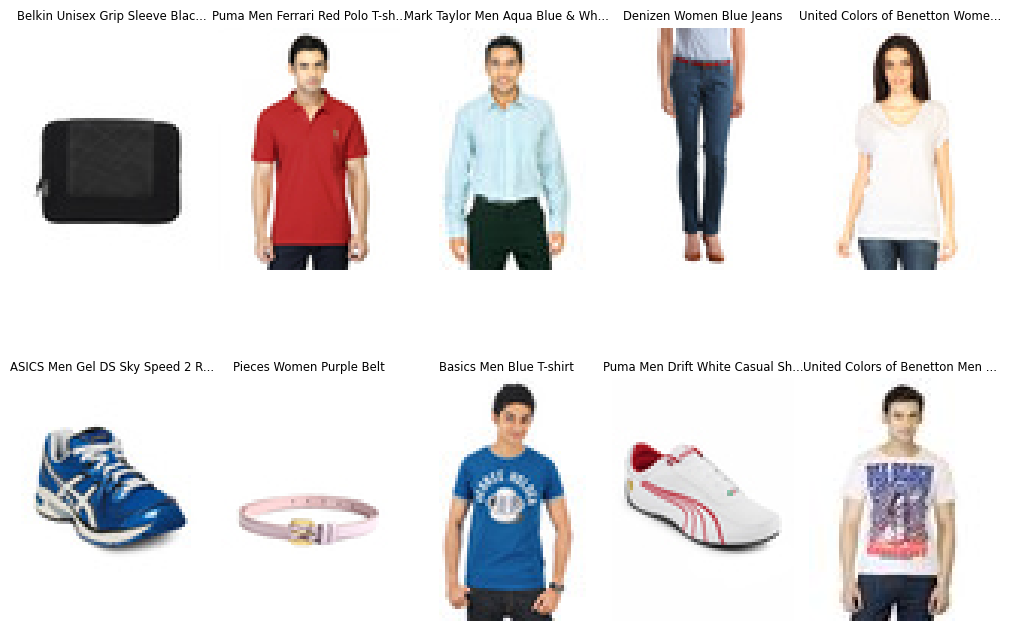

In [ ]:
random_indices = np.random.randint(0,len(dataset), 10)
display_images(dataset.select(random_indices), num_rows=2, num_columns=5, figsize=(10, 8), max_title_length=30)

## 3. Image Embeddings

In [ ]:
#embedding model
model_image = SentenceTransformer("sentence-transformers/clip-ViT-B-32")

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [ ]:
text_emb = model_image.encode("semantic search with vector databases")
size = sys.getsizeof("semantic search with vector databases")
print(f"size of text before embedding {size}")
print(f"size of text after embedding {text_emb.itemsize}")

size of text before embedding 86
size of text after embedding 4


In [ ]:
def embedder(example):
  image = example['image']
  image_embedding = model_image.encode(image).tolist()
  example['embeddings_image'] = image_embedding
  text = example['productDisplayName']
  text_embedding = model_image.encode(text).tolist()
  example['embeddings_text'] = text_embedding
  return example
dataset = dataset.map(embedder)

We are now ready to upsert the combination of ids, vectors and payload to our collection, and we'll do so in batches of 1000.

## Qdrant

**Supported Distances**
- Dot product
- Cosine similarity
- Euclidean distance
- Manhattan distance

[source](https://qdrant.tech/documentation/concepts/collections/)

**pricing**
1- Community
* Open Source & Free Forever
* Self-Hosted
* Full-Featured
* Organized Community Support
* Learning Resources & Docs

2- Managed Cloud - start from 25 dollars
* Free Tier Available
* Convenient User Interface
* Fully Managed & Monitored
* High Availability & Performance  
* Expert Technical Support

3- Enterprise - price on request

* Performance & Deployment
* On-Demand Horizontal Scaling
* Neural Network Fine-Tuning
* Migration and Monitoring
* Dedicated Technical Support

[source](https://qdrant.tech/pricing/)

In [ ]:
#connect to the vector database --> get those here :https://cloud.qdrant.io/
from qdrant_client.http.models import VectorParams, Distance
qdrant_url = userdata.get('qdrant_url')
qdrant_api_key =  userdata.get('qdrant_api_key')

client_q = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key
     )
# create collection
my_collection = "image_collection_test_2"
client_q.recreate_collection(
   collection_name=my_collection,
   vectors_config={
       "productDisplayName": VectorParams(
           size=512,
           distance=Distance.COSINE,
       ),
       "image": VectorParams(
           size=512,
           distance=Distance.COSINE,
       ),
   }
)

True

In [ ]:
df_dataset = dataset.to_pandas()
def insert_to_qdrant(dataset,batch_size = 1000):
  for index, row in df_dataset.iterrows():
    client_q.upsert(
        collection_name=my_collection,
        points=[
            PointStruct(
                id=index,
                vector={
                    "productDisplayName": row["embeddings_text"].tolist(),
                    "image": row["embeddings_image"].tolist(),
                },
                payload={"gender": row["gender"],
                         "masterCategory": row["masterCategory"],
                         "baseColour": row["baseColour"],
                         "season": row["season"],}
            )
        ]
    )
insert_to_qdrant(df_dataset,batch_size = 1000)

In [ ]:
results = client_q.search(
    collection_name=my_collection,
    query_vector=("productDisplayName", model_image.encode("pink shoes").tolist()),
    limit=3,
     #with_vectors=True,
    with_payload=True,)
id_list = [point.id for point in results]
results

[ScoredPoint(id=3195, version=3195, score=0.880795, payload={'baseColour': 'Pink', 'gender': 'Girls', 'masterCategory': 'Footwear', 'season': 'Winter'}, vector=None, shard_key=None),
 ScoredPoint(id=3344, version=3344, score=0.86307585, payload={'baseColour': 'Pink', 'gender': 'Women', 'masterCategory': 'Footwear', 'season': 'Summer'}, vector=None, shard_key=None),
 ScoredPoint(id=5889, version=5889, score=0.8540164, payload={'baseColour': 'Pink', 'gender': 'Women', 'masterCategory': 'Footwear', 'season': 'Winter'}, vector=None, shard_key=None)]

In [ ]:
def search_qdrant(data, name='productDisplayName', query_filter = None, limit=10):
  results = client_q.search(
    collection_name=my_collection,
    query_vector=(name, model_image.encode(data).tolist()),
    limit=limit,
    with_vectors=True,
    query_filter=query_filter,
    with_payload=True,)
  id_list = [point.id for point in results]
  Score_list = [point.score for point in results]
  return dict(zip(id_list, Score_list))

In [ ]:
filter_on_masterCategory = models.Filter(
    must=[
        models.FieldCondition(key="baseColour", match=models.MatchValue(value='Pink')),
         ]
    )

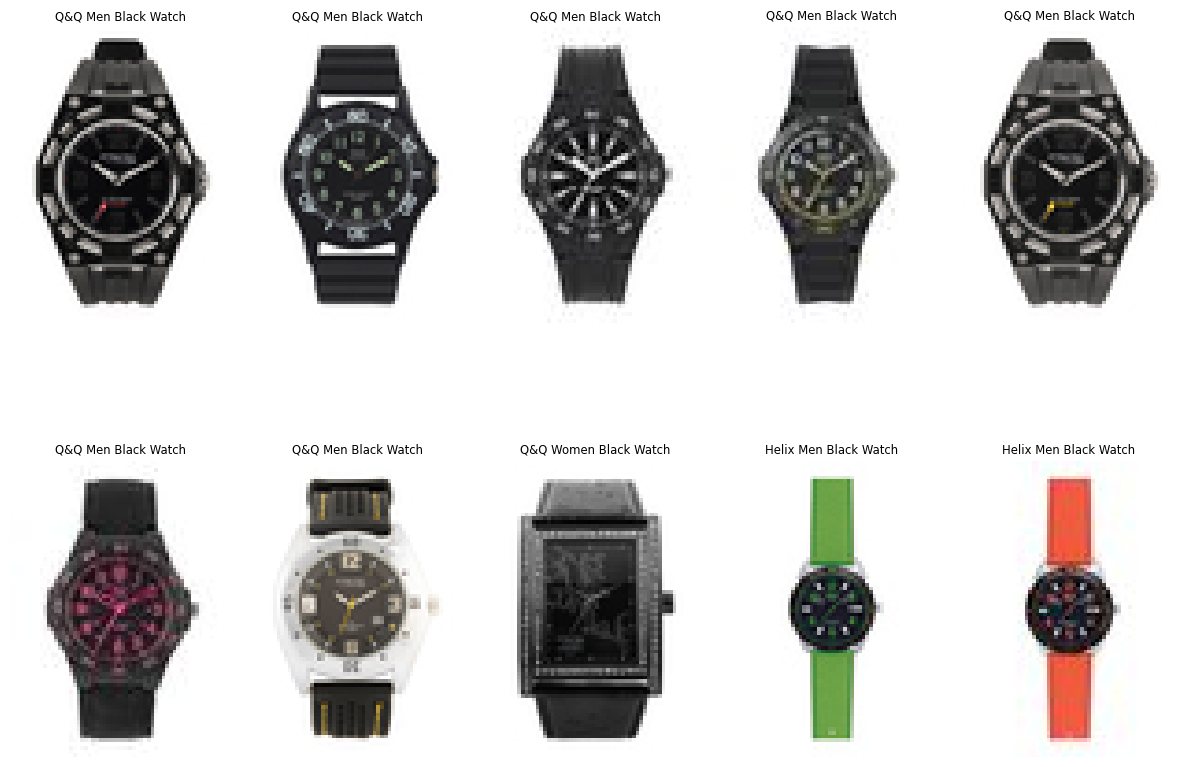

In [ ]:
id_list = search_qdrant("black watch", name = "productDisplayName")
filtered_dataset = dataset.select(id_list.keys())
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

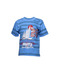

In [ ]:
dataset[1021]['image']

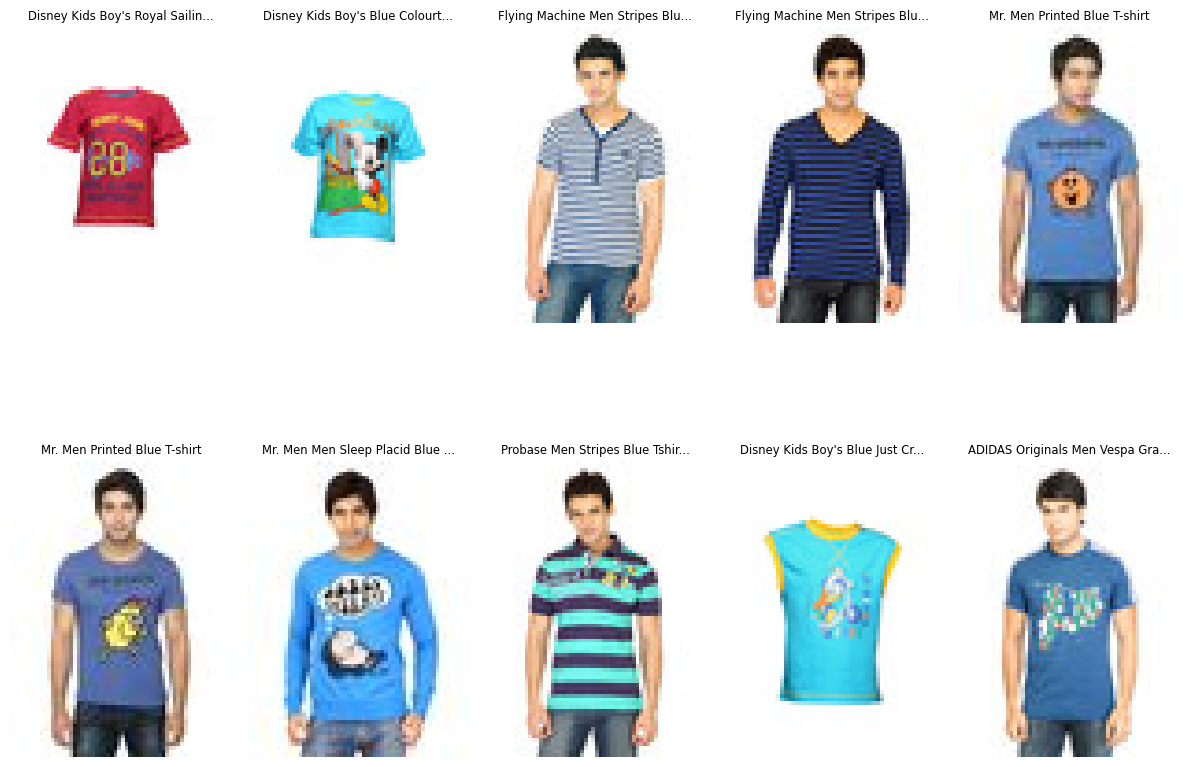

In [ ]:
id_list = search_qdrant(dataset[1021]['image'])
filtered_dataset = dataset.select(id_list.keys())
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

## Pinecone

**Supported Distances**


[source](https://qdrant.tech/documentation/concepts/collections/)

**Pods**: An index is made up of pods, which are units of cloud resources (vCPU, RAM, disk) that provide storage and compute for each index. Choose the pod type that works best for your use case.

**Indexes**: Indexes store your vector embeddings and metadata. Each index uses at least one pod, but you can add more to increase storage capacity.


[source](https://www.pinecone.io/pricing/)

**code**

In [ ]:
from pinecone import Pinecone, PodSpec
pinecone_key = userdata.get('pinecone_key')
pinecone_env =  userdata.get('pinecone_env')

pc = Pinecone(api_key=pinecone_key)

# choose a name for your index
index_name = "hybrid-image-search"
"""
pc.delete_index(index_name)
if index_name not in pc.list_indexes():
  pc.create_index(
      name=index_name,
      dimension=512,
      metric='cosine',
      spec=PodSpec(
          environment='us-east1-gcp',
          pod_type='p1.x1',
          pods=1,
          )
      )
"""
pc_index = pc.Index(name=index_name)

In [ ]:
images = dataset["image"]
df_dataset = dataset.to_pandas()
metadata=df_dataset.drop(["image", "embeddings_text","embeddings_image"],axis=1)
for i in metadata.columns:
  metadata[i] = metadata[i].astype(str)

bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])

bm25.encode_documents(["my name is umar", "this is a course"])

In [ ]:
bm25.encode_documents(["my name is umar", "this is a course"])

[{'indices': [3685696496, 2365787912],
  'values': [0.6186203955898605, 0.6186203955898605]},
 {'indices': [192565064], 'values': [0.6857534220147202]}]

In [ ]:
def insert(dataset, metadata,images,batch_size=1000):
  for i in tqdm(range(0, len(dataset), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(dataset))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = dataset[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = img_batch['embeddings_image']#model_image.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    pc_index.upsert(upserts)

insert(dataset, metadata,images,batch_size=100)
#pc_index.describe_index_stats()

In [ ]:
def search_pinecone_hybrid(query, index_name, bm25, model_image, limit=10):
  # create sparse and dense vectors
  if type(query) == str:
    sparse = bm25.encode_queries(query)
    dense = model_image.encode(query).tolist()
    # search
    result = pc_index.query(
        top_k=limit,
        vector=model_image.encode(query).tolist(),
        #filter={"year": "2015.0"},
        include_metadata=True)
  else:
    dense = model_image.encode(query).tolist()
    # search
    result = pc_index.query(
        top_k=limit,
        vector=dense,
        #filter={"year": "2015.0"},
        include_metadata=True)

  img_id = []
  scores = []
  for i in result["matches"]:
    img_id.append(int(i['metadata']['image_id']))
    scores.append(int(i['score']))
  return dict(zip(img_id, scores))

Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

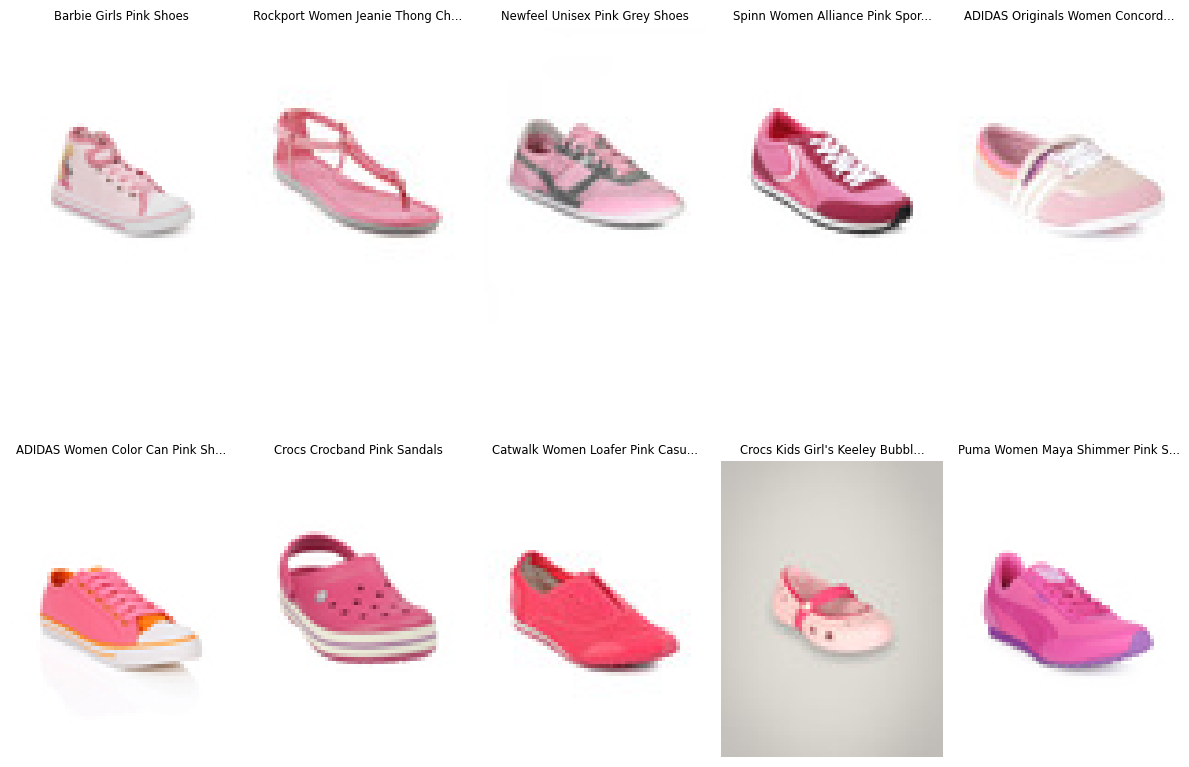

In [ ]:
query = "pink shoes"
img_dict= search_pinecone_hybrid(query, index_name, bm25, model_image)
filtered_dataset = dataset.filter(lambda example: example['image_id'] in img_dict.keys())
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

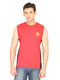

In [ ]:
dataset[75]['image']

Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

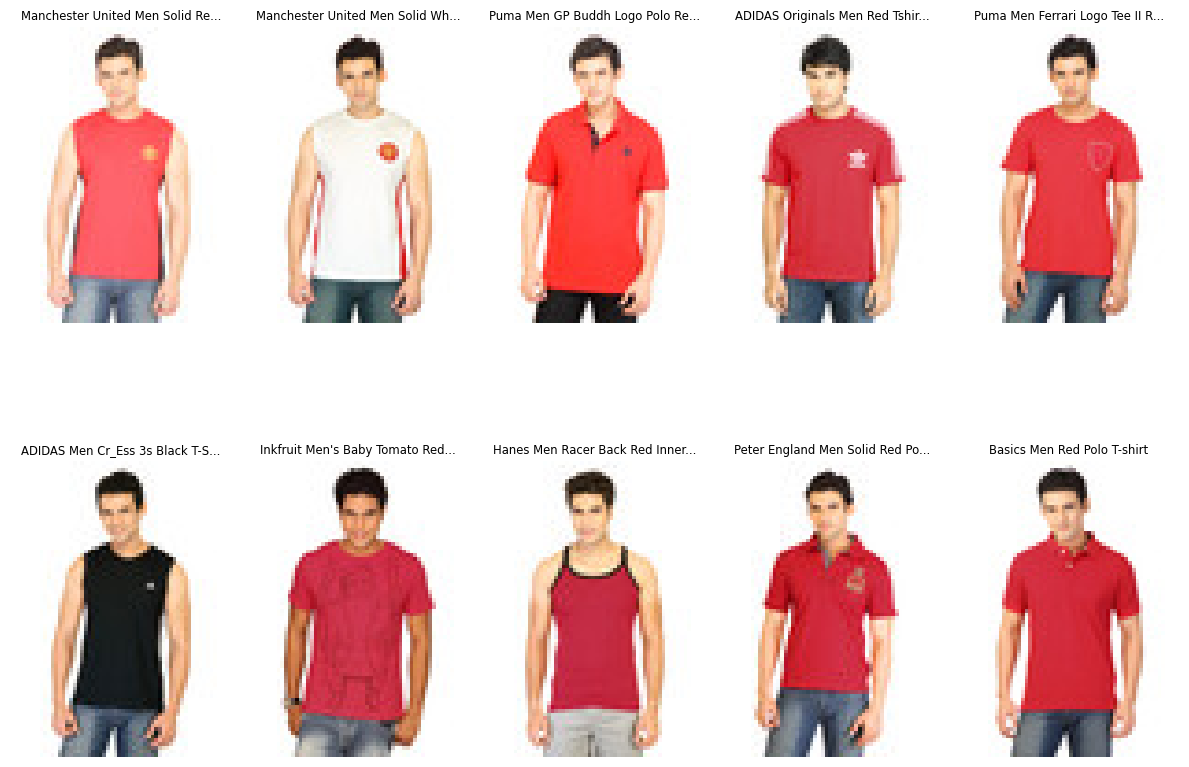

In [ ]:
img_dict= search_pinecone_hybrid(dataset[75]['image'], index_name, bm25, model_image)
filtered_dataset = dataset.filter(lambda example: example['image_id'] in img_dict.keys())
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

## Chroma


**Supported Distances**
 * Squared L2
 * Inner product
 * Cosine similarity
[source](https://docs.trychroma.com/usage-guide)

**pricing**

Free on local

[source](https://www.trychroma.com/)

In [ ]:
# Save images to folder
IMAGE_FOLDER = "images"
N_IMAGES = 15000
# Write the images to a folder
dataset_iter = iter(dataset)
os.makedirs(IMAGE_FOLDER, exist_ok=True)
for i in range(N_IMAGES):
    image = next(dataset_iter)['image']
    image.save(f"images/{i}.jpg")

# Create client object
client_c = chromadb.Client()
#define embedding model and ImageLoader object
embedding_function =OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

# Create collection
collection = client_c.create_collection(
    name='multimodal_collection',
    embedding_function=embedding_function,
    metadata={"hnsw:space": "cosine"} ,
    data_loader=image_loader)

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# Create Metadata
cols = ['gender','masterCategory','baseColour',
        'season','productDisplayName']
data_dict = dataset.to_pandas()[cols].to_dict(orient = 'records')

# Get the uris to the images as image name
image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER)])
ids = [str(i) for i in range(len(image_uris))]

# Insert data
collection.add(ids=ids, uris=image_uris, metadatas = data_dict)

In [ ]:
retrieved = collection.query(query_texts=["pink shoes"],
                             #query_images=np.array(dataset['image'][70]), --> for image querying
                             include=['data'],
                             #where={"gender": "Women"},
                             n_results=10)


id_list_c = [int(i.split("/")[-1].split(".")[0]) for i in retrieved["uris"][0]]
filtered_dataset = dataset.select(id_list_c)
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

In [ ]:
dataset['image'][70]

In [ ]:
retrieved = collection.query(query_images=np.array(dataset['image'][70]),
                             include=['data'],
                             #where={"metadata_field": "is_equal_to_this"},
                             n_results=10)

id_list_c = [int(i.split("/")[-1].split(".")[0]) for i in retrieved["uris"][0]]
filtered_dataset = dataset.select(id_list_c)
display_images(filtered_dataset, num_rows=2, num_columns=5, figsize=(12, 10))

## Further Readings

- https://towardsdatascience.com/modern-semantic-search-for-images-cb1a3242631d
https://cookbook.openai.com/examples/vector_databases/pinecone/using_pinecone_for_embeddings_search

-  https://medium.aiplanet.com/create-an-ecommerce-chat-application-to-search-images-and-text-using-langchain-pinecone-and-79a02c8018dd
https://blog.roboflow.com/pinecone-roboflow-inference-clip/

-  https://medium.aiplanet.com/create-an-ecommerce-chat-application-to-search-images-and-text-using-langchain-pinecone-and-79a02c8018dd

-  https://www.pinecone.io/learn/series/nlp/dense-vector-embeddings-nlp/

-  https://akgeni.medium.com/understanding-openai-clip-its-applications-452bd214e226


## Example datasets to try:

- https://www.kaggle.com/datasets/nfedorov/audio-summarization

- https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp

- https://www.kaggle.com/datasets/jacksoncrow/wikipedia-multimodal-dataset-of-good-articles